##  Proba invariante par l'algo itératif




In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.stats

### Rappels


> ***Théorème:*** Sous de bonnes hypothèses, la loi d'une chaine de Markov converge vers sa probabilité invariante.

#### ♡

***A vous:*** Rappelez $(2\heartsuit)$ quelles sont ces bonnes hypothèses ? (si besoin, retournez au chapitre précédent).



On peut utiliser ce théorème pour approximer la proba invariante. Lorsque l'espace d'état est grand, c'est un bien meilleur algorithme que celui qui consiste à diagonaliser la matrice. C'est un algorithme "itératif", qui fait partie de la même famille que les algos pour inverser de grosses matrices (notamment les matrices creuses).

> ***Proposition:*** Supposons qu'au temps zéro, la chaine de Markov ait comme distribution $\mu$. Alors au temps $t$ elle aura comme distribution $\mu P^t$ (les multiplications sont matricielles).


#### ♡

***A vous:*** Refaites la preuve sur du papier.




> ***Corrolaire:***  Quand il y a convergence en loi,  $t \to \mu P^t$ converge vers la probabilité invariante.

### Des probas comme de l'eau

On peut imaginer que les distributions de probabilité sont des répartitions d'eau: par exemple $\mu(x)=0.2$ signifie que l'état $x$ renferme $0.2$ litre d'eau.  L'opération matricielle "multiplication par $P$" transporte l'eau: elle coule en suivant les arrêtes du graphe et cela donne $\mu P$.
Illustrons cela avec une matrice de transition très simple: l'eau ne peut couler que vers la droite ou la gauche:

In [ ]:
def P_eau():
    P=np.zeros([5,5])
    P[0,1]=1
    P[1,2]=1
    P[2,1]=0.2
    P[2,3]=0.8
    P[3,4]=0.2
    P[3,2]=0.8
    P[4,3]=1
    return P

P=P_eau()

mu=np.array([0.5,0,0,0,0.5])

n_max=4
fig,axs=plt.subplots(n_max,1)
x=range(5)

for n in range(n_max):
    axs[n].bar(x,mu)
    axs[n].set_ylim(0,1)
    axs[n].set_title("répartition au temps %d"%n)
    mu=mu@P

fig.tight_layout()

Ici, il n'y a pas convergence en loi. Déjà la chaine est réductible: l'état 0 est quitté immadiatement pour ne plus jamais être visité.

Donc à partir de $t=1$ la chaine vie sur l'épace d'état réduit $[1,2,3,4]$. Mais cette nouvelle chaine de Markov est périodique de période 2. La répartition des proba oscille entre deux distributions
$$
\begin{pmatrix} 0 & \frac 1 6 & 0 & \frac 5 6 & 0 \end{pmatrix} \to
\begin{pmatrix} 0 & 0 & \frac 5 6 & 0 & \frac 1 6 \end{pmatrix} \to ...
$$
*Remarque:* Les 2 proba qui apparaissent ci-dessus sont les deux proba invariantes de $P^2$.

### Ehrenfest avec matrice creuse

Reprenons la matrice de transition de la chaine associée aux urnes d'Ehrenfest. Nous voulons estimer la probabilité invariante quand le nombre de particules $N$ est grand. Il est alors naturel de coder la matrice de transition avec une matrice creuse (=sparse). On utilise pour cela la bibliothèque `scipy.sparse`.

In [ ]:
"renvoie la matrice de transition sous la forme d'une matrice creuse"
def ehrenfest_sparse(N):
    P=scipy.sparse.lil_matrix((N+1,N+1),dtype=np.float64) #attention, la taille doit-être un tuple (et pas une liste)
    for x in range(1,N+1): P[x,x-1] = x/N
    for x in range(0,N): P[x,x+1] = (N-x)/N
    return P
P=ehrenfest_sparse(7)
print(P)

In [ ]:
np.set_printoptions(linewidth=2000, precision=2)
print(P.todense())

In [ ]:
N=30
P=ehrenfest_sparse(N)
t_max=10
pi=np.ones(N+1)/(N+1)
for t in range(1,t_max):
    pi=pi@P

x=np.arange(0,N+1)
plt.bar(x,pi,label="estimation")
plt.plot(x,scipy.stats.binom.pmf(x,n=N,p=0.5),"or",label="théorie");
plt.legend();

***A vous:*** Heu... Qu'est-ce qui se passe dans le graphique ci-dessus?


Ici, on a affiché la distribution de $Y_{10}$ en partant d'une distribution uniforme. Il n'est pas étonnant qu'à $t=10$ la répartition obtenue soit encore éloignée de la distribution lorsque $t \to +\infty$. En affichant $Y_n$ pour un $n$ plus grand, on voit cependant qu'on s'en approche. On peut aussi voir la périodicité de la chaîne en question, à travers la légère oscillation entre deux distributions distinctes:

In [ ]:
N=30
P=ehrenfest_sparse(N)
t_max=40
pi=np.ones(N+1)/(N+1)
for t in range(t_max):
    pi=pi@P

fig, ax = plt.subplots(2,2,figsize=(6,5),
                      sharex=True,sharey=True)

x = np.arange(0,N+1)
y_exact = scipy.stats.binom.pmf(x,n=N,p=0.5)

ax[0,0].set_title("n=40")
ax[0,0].bar(x,pi)
ax[0,0].plot(x, y_exact,".r")

pi = pi@P
ax[0,1].set_title("n=41")
ax[0,1].bar(x,pi)
ax[0,1].plot(x, y_exact,".r")

pi = pi@P
ax[1,0].set_title("n=42")
ax[1,0].bar(x,pi)
ax[1,0].plot(x, y_exact,".r")

pi = pi@P
ax[1,1].set_title("n=43")
ax[1,1].bar(x,pi)
ax[1,1].plot(x, y_exact,".r");

## Page ranking

### Principe

L'algorithme du page ranking est le suivant : on considère le web comme un graphe. Chaque lien étant une flèche. Toutes les flèches étant de même poids.  On calcule la probabilité invariante de ce graphe. Les pages ayant la plus grande probabilité invariante sont les meilleures.

Considérons par exemple ce mini-réseau internet.

***A vous:*** A l'œil, essayez d'estimer le ou les sites les plus visités par la chaine de Markov explorant ce graphe.

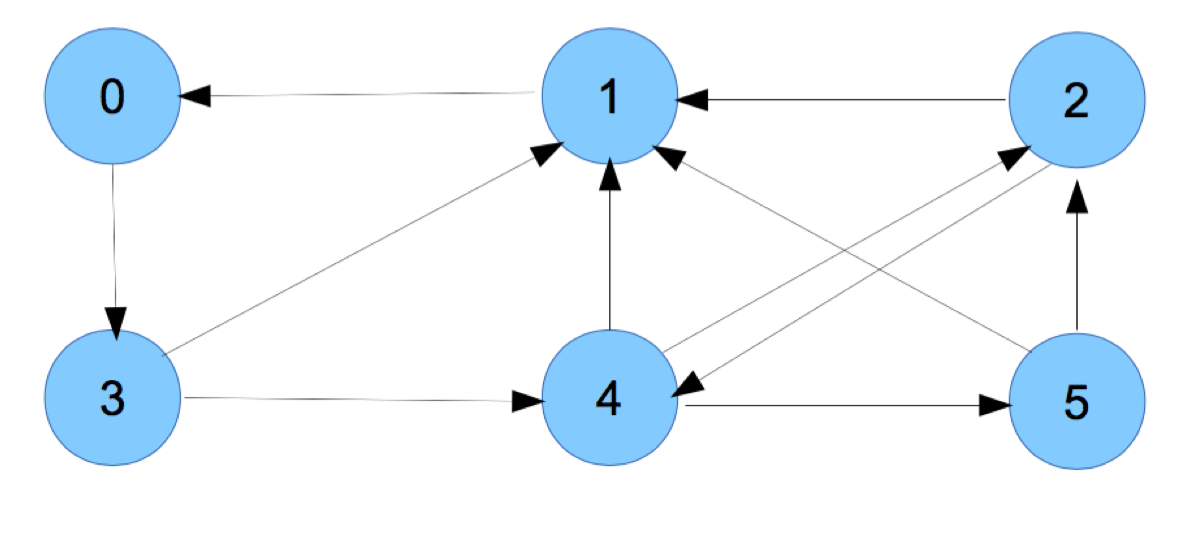

On voit que l'état auquel mènent le plus de flèches est l'état 1, qui envoie ensuite systématiquement sur l'état 0, qui à son tour envoie systématique sur l'état 3. Les sites les plus visités sont donc probablement les sites 1, 0 et 3. Pour vérifier cela on va calculer la proba invariante.

#### ♡♡

Entrons la matrice de transition associée au graphe ci-dessus dans une matrice creuse. Estimons la probabilité invariante en utilisant l'algorithme itératif.

In [ ]:
def P_exple():

    P=scipy.sparse.lil_matrix((6,6),dtype=np.float64)
    P[0,3] = 1
    P[1,0] = 1
    P[2,1] = 0.5
    P[2,4] = 0.5
    P[3,1] = 0.5
    P[3,4] = 0.5
    P[4,1] = 1/3
    P[4,2] = 1/3
    P[4,5] = 1/3
    P[5,1] = 0.5
    P[5,2] = 0.5

    return P

P = P_exple()
pi = np.ones(6)/6
for _ in range(20):

print(("pi :" + " {:.2f} "*6).format(*pi))

In [ ]:
#--- To keep following outputs, do not run this cell! ---

pi : 0.24  0.24  0.08  0.24  0.16  0.05 


### Le damping factor

Problème :  le réseau internet n'est pas vraiment irréductible et apériodique. Notamment, il y a plein de cul de sac.


Considérons le graphe ci-dessous. C'est un exemple très simple réductible. Que se passe-t-il si on essaye de calculer la probabilité invariante par l'algo itératif:


* Au temps $t=0$ de notre algorithme, on initialise $\mu_t(0) = \mu_t(1) = \mu_t(2) = \frac 1 3$.
* Au temps $t=1$, on a $\mu_t(0) = \frac 13, \mu_t(1) = \frac 2 3$, $\mu_t(2)=0$.
* Au temps $t=2$, on a $\mu_t(0) = \frac 23, \mu_t(1) = \frac 1 3$, $\mu_t(2)=0$.
* Puis, à tous les temps impairs, on retombera dans la situation du temps $1$.
* Puis, à tous les temps pairs, on retombera dans la situation du temps $2$.



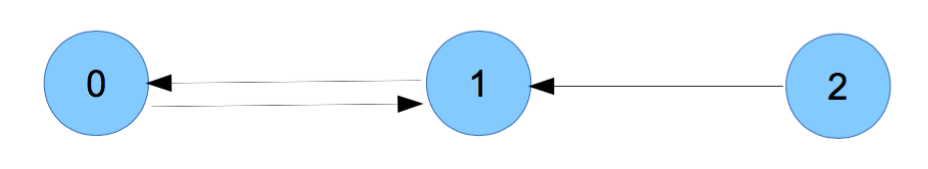


Pour corriger ce problème,  Sergueï Brin et Larry  Page, les fondateurs de Google, ont décidé de calculer les notes  $\pi$  en résolvant le système :
$$
\pi =  \frac {(1-d)} N  \cdot \mathbf 1 +   d \cdot  \pi  P
$$
où $\cdot$ est la multiplication scalaire*vecteur, $d$ est le *damping Factor* et est fixé empiriquement à 0.85, $N$ est le nombre d'états, et $\mathbf 1 = (1,1,....,1)$.


Si l'on pose $P_d = d \cdot P +   \frac {(1-d)} N  \mathbf {O}$ avec $\mathbf {O}$ la matrice remplie de 1, alors, en utilisant le fait que la somme des éléments de $\pi$ vaut 1,  l'équation ci-dessus s'écrit simplement:
$$
\pi = \pi P_d
$$   
Ainsi, on  a l'interprétation suivante : $\pi$ représente le temps moyen passé dans chaque état par un web-surfeur, qui passe de site en site en suivant les liens avec proba 85\%, et qui, avec une proba de
15\% choisit une page complètement au hasard.  Remarquons que le graphe associé est maintenant irréductible, et que la matrice de transition est pleine. Cependant on ne va jamais stocker cette matrice. On va plutôt modifier l'itération de l'algorithme itératif:


$$
\pi_{t+1} =  \frac {(1-d)} N  \cdot \mathbf 1 +   d \cdot  \pi_t  P
$$


In [ ]:
# damping factor
d = 0.85

def damp_markov_from_P(P, x0, t_max=20):

    N = P.shape[0]
    ones = np.ones(N)
    X = [x0]

    xt = x0
    for t in range(t_max):
        xt = ...
        X.append(xt)

    return X

Appliquons-le au mini-réseau de 6 sites :

In [ ]:
P = P_exple()
x0 = np.ones(6)/6
t_max = 100

X = damp_markov_from_P(P, x0, t_max)
pi = X[-1]

print(("pi :" + " {:.2f} "*6).format(*pi))

In [ ]:
#--- To keep following outputs, do not run this cell! ---

pi : 0.22  0.23  0.10  0.21  0.16  0.07 


Appliquons-le à la chaîne de Markov remplie d'eau :

In [ ]:
P = P_eau()
x0 = np.array([0.5,0,0,0,0.5])
t_max = 6

X = damp_markov_from_P(P, x0, t_max)
x = np.arange(5)

fig, ax = plt.subplots(t_max, 1, figsize=(4,6))
for n in range(t_max):
    ax[n].bar(x, X[n])
    ax[n].set_ylim(0,1)
    ax[n].set_title("répartition au temps %d"%n)

fig.tight_layout()

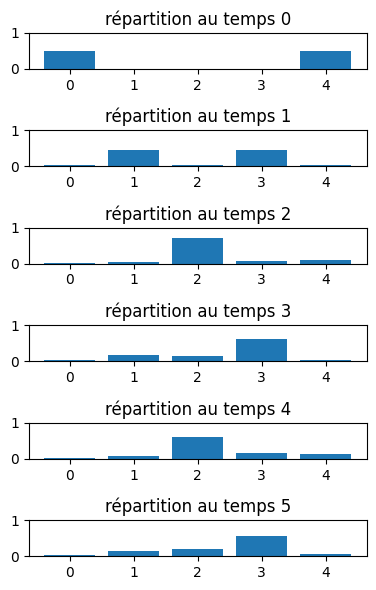

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Appliquons-le au réseau de 3 états :

In [ ]:
P = np.array([[0,1,0],
              [1,0,0],
              [0,1,0]])
x0 = np.array([1/3,1/3,1/3])
t_max = 6

X = damp_markov_from_P(P, x0, t_max)
x = np.arange(3)

fig, ax = plt.subplots(t_max, 1, figsize=(4,6))
for n in range(t_max):
    ax[n].bar(x, X[n])
    ax[n].set_ylim(0,1)
    ax[n].set_title("répartition au temps %d"%n)

fig.tight_layout();

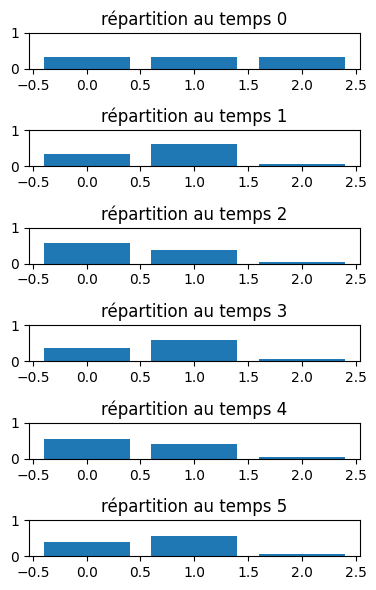

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Vous pouvez pousser plus loin les itérations pour voir que la distribution converge bel et bien.